Student Information
Name:蕭宜芳
Student ID:112034584
GitHub ID:yy223xiao
Kaggle name:Xiaoooyifang
Kaggle private scoreboard snapshot:

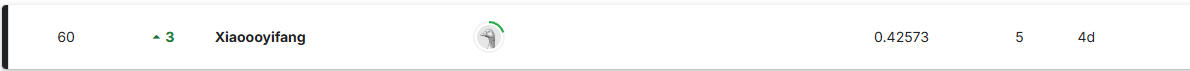

In [1]:
from IPython.display import Image
Image(filename="C://Users//yuan//Desktop//DM2024-Lab2-Master-main//pic0.PNG",width=400,height=400)

In [ ]:
import pandas as pd
import json


1.Read Data:Load the tweet data from a JSON file. Each tweet is extracted and stored in a list, which is then converted into a DataFrame for further processing.
2.Load Data Identification:Import the data identification file, which contains metadata or unique identifiers for each tweet.
3.Merge the Emotion Labels and Data Identification Information:Combine the emotion labels and identification data with the main tweet dataset using the common tweet_id column. This ensures all necessary information is unified in one DataFrame.
4.Filter Rows That Have an Emotion Label:Remove rows that lack emotion labels (NaN) to focus on tweets with defined emotion categories.

In [ ]:

tweets_data = []
with open('tweets_DM.json', 'r', encoding='utf-8') as f:
    for line in f:
        try:
            tweet = json.loads(line)
            tweets_data.append(tweet["_source"]["tweet"])
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")
tweets_df = pd.DataFrame(tweets_data)

In [4]:
# Load emotion labels
emotion_df = pd.read_csv('emotion.csv')

# Load data identification
identification_df = pd.read_csv('data_identification.csv')

# Merge the emotion labels and data identification information
tweets_df = tweets_df.merge(emotion_df, left_on='tweet_id', right_on='tweet_id', how='left')
tweets_df = tweets_df.merge(identification_df, left_on='tweet_id', right_on='tweet_id', how='left')

# Filter rows that have an emotion label
labeled_tweets_df = tweets_df[~tweets_df['emotion'].isna()]


Reasons for Choosing the LightGBM Model:
1.Efficiency and Scalability:LightGBM is highly efficient, making it suitable for handling large, high-dimensional datasets like TF-IDF features from text.
2.Support for Multiclass Classification:LightGBM natively supports multiclass classification, essential for emotion recognition tasks.
3.Handling Sparse Data:It excels with sparse, high-dimensional data, which aligns well with text data represented as TF-IDF.
4.Regularization:Built-in regularization techniques (e.g., lambda_l1, lambda_l2) help reduce overfitting, crucial for text data.
5.Fast Training:Its histogram-based algorithm ensures faster training and prediction, allowing for efficient experimentation.

1.Dataset Preparation:The dataset is split into training and testing subsets based on the identification column.Training data contains rows with identification == 'train'.Testing data contains rows with identification == 'test'.
2.Handling Missing Values:Ensure all text inputs are strings and handle any missing values by replacing None or NaN with an empty string.
3.Train-Validation Split:The training dataset is split into a training set and a validation set to evaluate model performance during training.The split is stratified to maintain the proportion of each emotion category.
4.Label Encoding;Encode categorical emotion labels into numerical format using LabelEncoder.
5.TF-IDF Vectorization:Convert text data into numerical feature representations using TF-IDF (Term Frequency-Inverse Document Frequency).The vectorizer is configured with:max_features=10000: Use up to 10,000 most relevant features.ngram_range=(1, 2): Include both unigrams and bigrams.The vectorizer is applied to the training, validation, and test datasets.
6.Dataset Creation for LightGBM:Prepare datasets in the format required by LightGBM for training and validation.
7.Model Configuration:
    Set the parameters for the LightGBM model:
    objective: Multiclass classification.
    num_class: Number of emotion categories (from LabelEncoder).
    boosting_type: Gradient Boosted Decision Trees (gbdt).
    metric: Multi-class log loss (multi_logloss).
    num_leaves: Maximum number of leaves per tree (128).
    learning_rate: Learning rate (0.03).
    max_bin: Maximum number of bins for discretizing continuous features (255).
    feature_fraction: Use 70% of features for training.
    bagging_fraction: Use 60% of samples for training.
    bagging_freq: Perform bagging every 5 iterations.
    min_data_in_leaf: Minimum data points in each leaf (100) to avoid overfitting.
    lambda_l1 and lambda_l2: Regularization parameters to reduce model complexity.
    seed: Random seed for reproducibility.

In [5]:
#!pip install lightgbm
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import json
train_data = tweets_df[tweets_df['identification'] == 'train']
test_data = tweets_df[tweets_df['identification'] == 'test']


In [6]:

X_train_text = train_data['text'].values
y_train_text = train_data['emotion'].values
X_test_text = test_data['text'].values
test_ids = test_data['tweet_id'].values


In [7]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

X_train_text = np.array(["" if x is None else str(x) for x in X_train_text])  # Handle None/NaN and ensure strings
X_test_text = np.array(["" if x is None else str(x) for x in X_test_text])

In [8]:
X_train_text, X_val_text, y_train_text, y_val_text = train_test_split(
    X_train_text, y_train_text, test_size=0.2, random_state=42, stratify=y_train_text
)


In [9]:
le = LabelEncoder()
y_train = le.fit_transform(y_train_text)
y_val = le.transform(y_val_text)

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_val_tfidf = vectorizer.transform(X_val_text)
X_test_tfidf = vectorizer.transform(X_test_text)

In [10]:
train_dataset = lgb.Dataset(X_train_tfidf, label=y_train)
val_dataset = lgb.Dataset(X_val_tfidf, label=y_val, reference=train_dataset)

params = {
    "objective": "multiclass",
    "num_class": len(le.classes_),
    "boosting_type": "gbdt",
    "metric": "multi_logloss",
    "num_leaves": 128,
    "learning_rate": 0.03,
    "max_bin": 255,
    "feature_fraction": 0.7,  # 使用 70% 特徵
    "bagging_fraction": 0.6,  # 使用 60% 樣本
    "bagging_freq": 5,
    "min_data_in_leaf": 100,  # 增加最小葉子數據量
    "lambda_l1": 2.0,         # 強化正則化
    "lambda_l2": 2.0,
    "seed": 42
}


Model Training
1.The lgb.train() function is used to train the LightGBM model:Parameters (params): Includes settings for multiclass classification and regularization.Training Data (train_dataset): The dataset used to fit the model.Validation Data (val_dataset): Used to monitor performance and avoid overfitting.
2.Predictions are made on the test data (X_test_tfidf) using the trained model:model.predict(): Generates probability predictions for each class.argmax(axis=1): Converts probabilities to class labels by selecting the class with the highest probability.
3.Inverse Transform of Labels:Convert predicted numeric class labels back to their original emotion labels using the LabelEncoder.
4.Result Formatting:Combine test IDs with predicted emotions into a list of dictionaries for easier interpretation and saving.



In [11]:
model = lgb.train(
    params,
    train_dataset,
    num_boost_round=2000,
    valid_sets=[train_dataset, val_dataset],
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(period=50)  # 減少日誌顯示頻率
    ]
)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 11.943399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 542415
[LightGBM] [Info] Number of data points in the train set: 1164450, number of used features: 9997
[LightGBM] [Info] Start training from score -3.597586
[LightGBM] [Info] Start training from score -1.765956
[LightGBM] [Info] Start training from score -2.347946
[LightGBM] [Info] Start training from score -3.124284
[LightGBM] [Info] Start training from score -1.037009
[LightGBM] [Info] Start training from score -2.018193
[LightGBM] [Info] Start training from score -3.396878
[LightGBM] [Info] Start training from score -1.957811
Training until validation scores don't improve for 100 rounds
[50]	training's multi_logloss: 1.35922	valid_1's multi_logloss: 1.36822
[100]	training's multi_logloss: 1.27209	valid_1's multi_logloss: 1.28754
[

In [12]:
predictions_proba = model.predict(X_test_tfidf)

In [14]:


predicted_classes = predictions_proba.argmax(axis=1)
predicted_emotions = le.inverse_transform(predicted_classes)
results = [{"id": id_, "emotion": emotion} for id_, emotion in zip(test_ids, predicted_emotions)]

# 將結果保存為 JSON 文件
output_file = "predicted_emotionsv2.json"
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(results, f, indent=4, ensure_ascii=False)

print(f"預測結果已保存到 {output_file}")


預測結果已保存到 predicted_emotionsv2.json


In [16]:
input_file = "predicted_emotionsv2.json"
with open(input_file, "r", encoding="utf-8") as f:
    data = json.load(f)

# 將 JSON 數據轉換為 DataFrame
df = pd.DataFrame(data)

# 保存為 CSV 文件
output_file = "predicted_emotionsv2.csv"
df.to_csv(output_file, index=False, encoding="utf-8")

print(f"JSON 已成功轉換為 CSV，保存至 {output_file}")

JSON 已成功轉換為 CSV，保存至 predicted_emotionsv2.csv


In [17]:
df = pd.read_csv('predicted_emotions.csv')
num_records = len(df)
print(f"CSV 文件共有 {num_records} 筆資料。")

CSV 文件共有 411972 筆資料。


Using common metrics like accuracy, precision, recall, and F1-score. This code assumes you have y_val (true labels) and predictions_proba (predicted probabilities) for the validation set.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np

# Convert predicted probabilities to predicted classes for the validation set
val_predicted_classes = model.predict(X_val_tfidf).argmax(axis=1)
val_predicted_emotions = le.inverse_transform(val_predicted_classes)
true_emotions = le.inverse_transform(y_val)

# Evaluate metrics
accuracy = accuracy_score(true_emotions, val_predicted_emotions)
precision = precision_score(true_emotions, val_predicted_emotions, average='weighted')
recall = recall_score(true_emotions, val_predicted_emotions, average='weighted')
f1 = f1_score(true_emotions, val_predicted_emotions, average='weighted')

# Detailed classification report
report = classification_report(true_emotions, val_predicted_emotions)

# Print evaluation results
print("Evaluation Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:\n")
print(report)

# Save evaluation results to a file
evaluation_results = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1_score": f1,
    "classification_report": report
}

output_evaluation_file = "evaluation_results.json"
with open(output_evaluation_file, "w", encoding="utf-8") as f:
    json.dump(evaluation_results, f, indent=4, ensure_ascii=False)

print(f"Evaluation results saved to {output_evaluation_file}")


In [ ]:
#Other model :predicted_emotions_lstm5555.csv
#the score is 0.28369

In [ ]:
#the code
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dropout, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec
train_data = labeled_tweets_df
test_data = tweets_df['identification'] == 'test'
X_train_data = train_data['text'].values
y_train_data = train_data['emotion'].values

# 編碼情緒標籤
le = LabelEncoder()
y_train = le.fit_transform(y_train_data)

# 訓練與驗證集分割
X_train, X_val, y_train, y_val = train_test_split(X_train_data, y_train, test_size=0.2, random_state=42, stratify=y_train)
# 文字 Tokenization 與 Padding
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
###Bidirectional LSTM ##################################
from tqdm import tqdm
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, GlobalMaxPooling1D, Dropout, Dense
embedding_dim = 100
word_index = tokenizer.word_index
vocab_size = min(len(word_index) + 1, 10000)
embedding_matrix = np.zeros((vocab_size, embedding_dim))
# 構建詞嵌入矩陣（使用 tqdm 查看進度）
for word, i in tqdm(word_index.items(), desc="Building Embedding Matrix"):
    if i >= vocab_size:
        continue
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]
        
# 替換 CNN 為 Bidirectional LSTM 模型
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True),
    Bidirectional(LSTM(128, return_sequences=True)),  # 雙向 LSTM 層
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(le.classes_), activation='softmax')  # 多分類輸出
])
model.compile(
    optimizer='adam',  # 使用 Adam 优化器
    loss='sparse_categorical_crossentropy',  # 使用稀疏交叉熵损失函数
    metrics=['accuracy']  # 指标包括准确率
)
# 使用 GPU 訓練
with tf.device('/gpu:0'):  # 強制使用 GPU
    history = model.fit(
        X_train_pad, y_train,
        validation_data=(X_val_pad, y_val),
        batch_size=128,  # 批量大小
        epochs=10,       # 訓練 epoch 數
        verbose=1        # 顯示訓練日誌
    )
###Bidirectional LSTM ##################################

In [ ]:
#Other model :emotion_predictions_CNN.csv
#the score is 0.0.27182

In [ ]:
#the code
# 初始化詞嵌入矩陣
from tqdm import tqdm
from tensorflow.keras.callbacks import Callback

embedding_dim = 100
word_index = tokenizer.word_index
vocab_size = min(len(word_index) + 1, 10000)
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tqdm(word_index.items(), desc="Building Embedding Matrix"):
    if i >= vocab_size:
        continue
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]
# 構建 CNN 模型
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False),
    Conv1D(filters=256, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(le.classes_), activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
with tf.device('/gpu:0'):  
    history = model.fit(
        X_train_pad, y_train,
        validation_data=(X_val_pad, y_val),
        batch_size=128,
        epochs=10,
        verbose=1
    )

Model Feature Comparison
LightGBM (Gradient Boosting Tree Model)
Characteristics:

Strong capability to handle sparse and high-dimensional features (e.g., TF-IDF or Bag-of-Words representations).
Quick convergence with minimal tuning, suitable for small sample datasets.
Fast training speed, particularly efficient on small to medium-sized datasets.
Advantages:
Excels at structured data and handcrafted features.
Robust against noise and nonlinear relationships in data.
Efficient in handling imbalanced datasets.
LSTM (Long Short-Term Memory Network)
Characteristics:

Specially designed for sequential data, capable of capturing long-term dependencies.
Suitable for processing longer sentences to extract contextual semantics.
Disadvantages:
Longer training time and heavily reliant on large datasets for good performance.
Prone to overfitting, especially on small datasets, leading to unstable results.
CNN (Convolutional Neural Network)
Characteristics:

Excels at capturing local contextual features (e.g., keyword sequences).
Faster training compared to LSTM and less reliant on long-term dependencies.
Disadvantages:
Limited in capturing global semantic information across sequences.
May underperform tree models when feature engineering is insufficient.